In [154]:
import tensorflow as tf
import sklearn as sk
import numpy as np


**Official Task 1:**

- [x] Download dogs and cats images/labels frm: https://www.kaggle.com/c/dogs-vs-cats
- [x] Build the best CNN  you can with fixed: epochs = 12; to import this data look into:https://keras.io/api
(do not worry about overfitting/underfitting, just try to make it work whichever way you can, this is only a beginner demo)

**More advanced (unofficial) tasks:**

- [x] Task 2:) if you completed task 2 a) look for other dogs and cat images in the internet and use those to test your classifier with (again just try to make it work) (this may require that you can compare the images you find with the images you have, so you dont test with duplicates)

- [ ] Task 3:)  (if you realy want to 'burn'): Remove the classifier part after training (so only maintain the features learned) and train a totaly different classifier than neural networks (even linear regression is ok) (answer is somewhere within: https://keras.io/api)

**Comments**
I wasn't exactly sure what materials I was allowed to use besides the lecture notes. For this reason, I cite sources that helped me further understand the topic and prepare the solution:
1. https://www.kaggle.com/darthmanav/dog-vs-cat-classification-using-cnn
2. https://www.kaggle.com/xiormeesh/cnn-cats-vs-dogs-classification
3. https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

The main difficulties were associated with tuning the operation of the M1 chip, which turned out to be a non-trivial task. After training with a standard dataset, I tried to experiment with pictures downloaded from the Internet (owned by users, thanks to them). Unfortunately, the model was not able to predict anything with the minimum level of accuracy at all. Perhaps I made a mistake in the image size settings and they should correspond to the trained model.

In [155]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from PIL import Image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./Downloads/dogs-vs-cats"))

['.DS_Store', 'sampleSubmission.csv', 'test1', 'train', 'test2']


In [156]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [157]:
filenames = os.listdir("./Downloads/dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [158]:
df.head()


filename  category
0   dog.8011.jpg         1
1   cat.5077.jpg         0
2   dog.7322.jpg         1
3   cat.2718.jpg         0
4  cat.10151.jpg         0

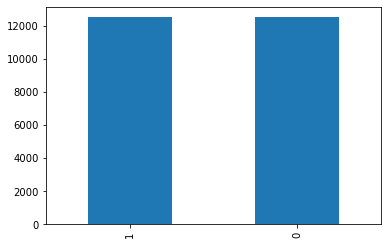

In [159]:
df['category'].value_counts().plot.bar()


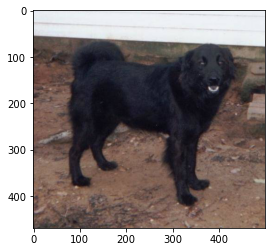

In [160]:
sample = random.choice(filenames)
image = load_img("./Downloads/dogs-vs-cats/train/"+sample)
plt.imshow(image)

In [161]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()




model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 8)       224       
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 8)       32        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 8)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 16)        1168      
_________________________________________________________________
batch_normalization_14 (Batc (None, 61, 61, 16)        64        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 16)       

In [162]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [163]:
earlystop = EarlyStopping(patience=10)


In [164]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [165]:
callbacks = [earlystop, learning_rate_reduction]


In [166]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 


In [167]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


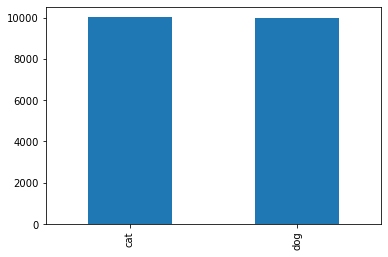

In [168]:
train_df['category'].value_counts().plot.bar()


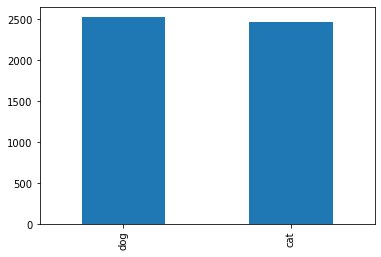

In [169]:
validate_df['category'].value_counts().plot.bar()


In [170]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [171]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./Downloads/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 20000 validated image filenames belonging to 2 classes.


In [172]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./Downloads/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [173]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./Downloads/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


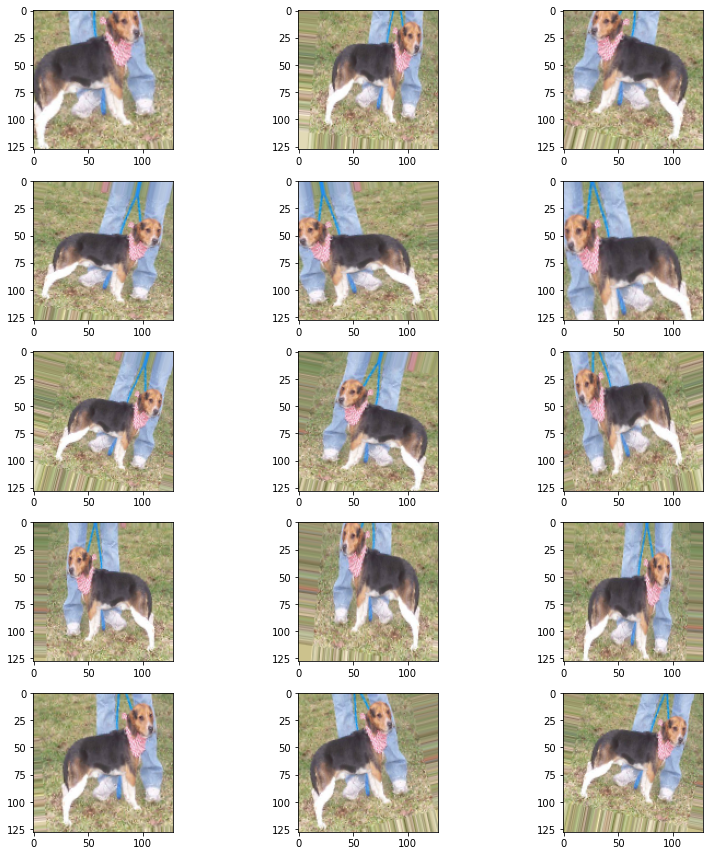

In [174]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [175]:
epochs=12
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/12
1333/1333 [==============================] - 1209s 907ms/step - loss: 0.6990 - accuracy: 0.6280 - val_loss: 0.5361 - val_accuracy: 0.5936
Epoch 2/12


/Users/konsta/opt/anaconda3/envs/tf/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 512s 384ms/step - loss: 0.5910 - accuracy: 0.6900 - val_loss: 1.1538 - val_accuracy: 0.5751
Epoch 3/12
1333/1333 [==============================] - 523s 392ms/step - loss: 0.5594 - accuracy: 0.7146 - val_loss: 0.8416 - val_accuracy: 0.7529
Epoch 4/12
1333/1333 [==============================] - 627s 471ms/step - loss: 0.5334 - accuracy: 0.7358 - val_loss: 0.4556 - val_accuracy: 0.7027
Epoch 5/12
1333/1333 [==============================] - 860s 645ms/step - loss: 0.5131 - accuracy: 0.7519 - val_loss: 0.2233 - val_accuracy: 0.7906
Epoch 6/12
1333/1333 [==============================] - 1061s 796ms/step - loss: 0.5012 - accuracy: 0.7597 - val_loss: 0.8584 - val_accuracy: 0.5571
Epoch 7/12
1333/1333 [==============================] - 1566s 1s/step - loss: 0.4906 - accuracy: 0.7646 - val_loss: 0.4749 - val_accuracy: 0.6455
Epoch 8/12
1333/1333 [==============================] - 1833s 1s/step - loss: 0.4781 - accuracy: 0.7722 - val_loss: 0.6825 -

In [176]:
model.save_weights("model.h5")


In [177]:
test_filenames = os.listdir("./Downloads/dogs-vs-cats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [178]:
nb_samples

12500

In [179]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./Downloads/dogs-vs-cats/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [180]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [194]:
test_df['category'] = np.argmax(predict, axis=-1)


In [195]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [196]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

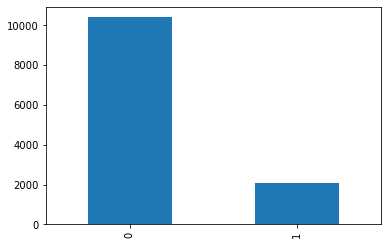

In [197]:
test_df['category'].value_counts().plot.bar()


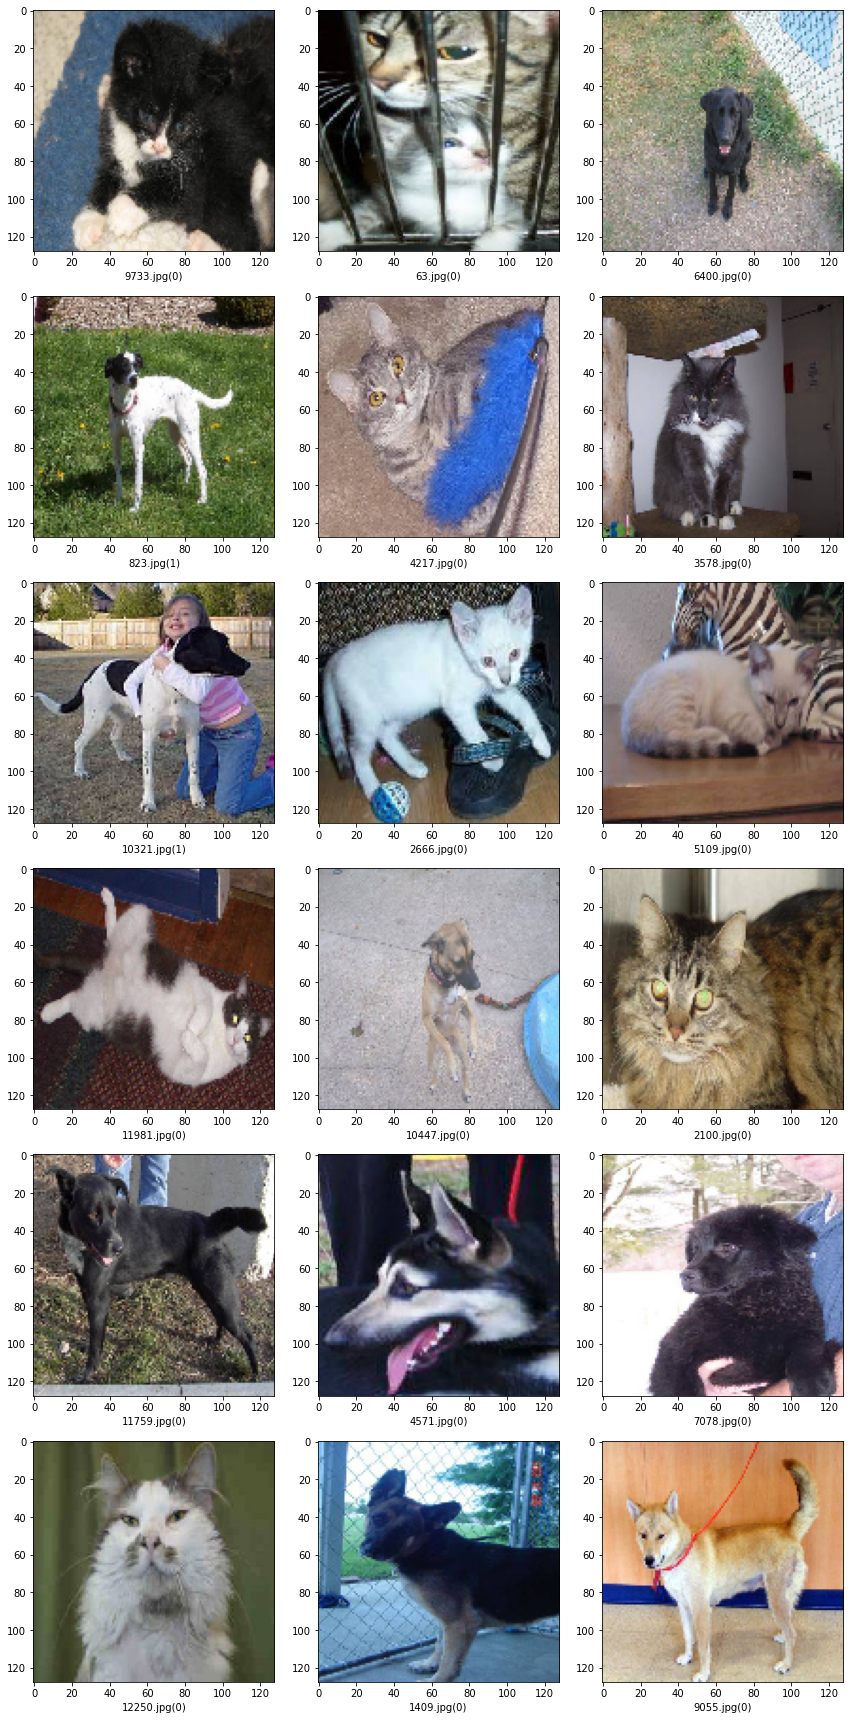

In [198]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./Downloads/dogs-vs-cats/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()


**And here is the try with a bunch of pictures from internet**

In [199]:
test_filenames2 = os.listdir("./Downloads/dogs-vs-cats/test2")
test_df2 = pd.DataFrame({
    'filename': test_filenames2
})
nb_samples2 = test_df2.shape[0]

In [200]:
test_df2

filename
0   47.jpeg
1   10.jpeg
2   26.jpeg
3   30.jpeg
4   31.jpeg
5   27.jpeg
6    1.jpeg
7   11.jpeg
8   46.jpeg
9   20.jpeg
10  36.jpeg
11  41.jpeg
12  16.jpeg
13   7.jpeg
14  17.jpeg
15  40.jpeg
16  37.jpeg
17  21.jpeg
18  34.jpeg
19   8.jpeg
20  22.jpeg
21  18.jpeg
22  38.jpeg
23   4.jpeg
24  14.jpeg
25  43.jpeg
26  15.jpeg
27   5.jpeg
28  39.jpeg
29  19.jpeg
30  23.jpeg
31   9.jpeg
32  35.jpeg
33   2.jpeg
34  28.jpeg
35  12.jpeg
36  45.jpeg
37  32.jpeg
38  24.jpeg
39  48.jpeg
40  25.jpeg
41  33.jpeg
42  44.jpeg
43  13.jpeg
44  29.jpeg
45   3.jpeg

In [201]:
test_gen2 = ImageDataGenerator(rescale=1./255)
test_generator2 = test_gen2.flow_from_dataframe(
    test_df2, 
    "./Downloads/dogs-vs-cats/test2", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 46 validated image filenames.


In [202]:
predict2 = model.predict_generator(test_generator2, steps=np.ceil(nb_samples2/batch_size))

In [203]:
np.ceil(nb_samples2/batch_size)

4.0

In [204]:
print(predict2.shape)

(46, 2)


In [205]:
test_df2['category'] = np.argmax(predict2, axis=-1)


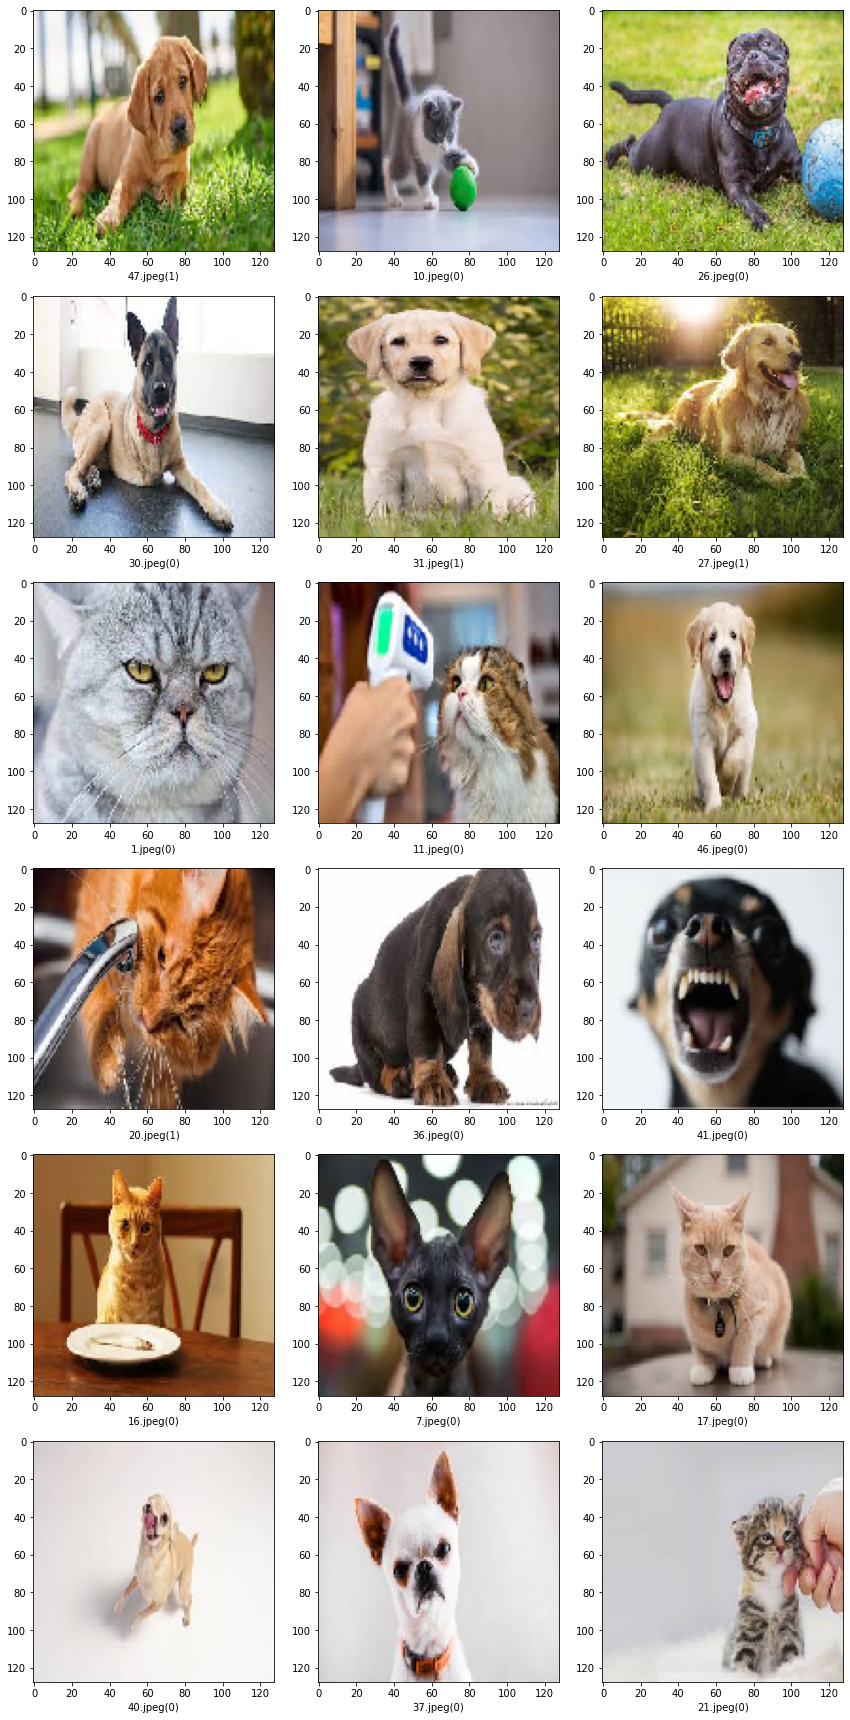

In [206]:
sample_test2 = test_df2.head(18)
sample_test2.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test2.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./Downloads/dogs-vs-cats/test2/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()